In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
repo_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning'
experiments_path = os.path.join(repo_path, 'experiments/HAM10000/8:1:1')

In [3]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_best_epoch(df, window_size):
    val_auroc = np.array(df.val_auroc.to_list())
    windowed_auroc = [sum(val_auroc[index-window_size:index])/window_size \
                      for index in range(window_size, len(val_auroc))]
    return df.iloc[window_size+np.argmax(windowed_auroc)]

In [4]:
random_states = [1001, 2001, 3001]
#random_states = [4001, 5001, 6001]
prior_scales = np.logspace(0, 9, num=10)
lr_0s = np.logspace(-1, -4, num=4)
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
weight_decays = [0.0]
window_size = 5

In [5]:
columns = ['random_state', 'prior_scale', 'test_auroc', 'test_loss', 'test_nll', 
           'test_prior', 'train_auroc', 'train_loss', 'train_nll', 'train_prior', 
           'val_auroc', 'val_loss', 'val_nll', 'val_prior']
df = pd.DataFrame(columns=columns)

for row_index, (random_state, prior_scale) in enumerate(itertools.product(random_states, prior_scales)):    
    # Get best model
    best_row = None
    for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
        df_path =  '{}/learned_lr_0={}_n=1000_prior_scale={}_random_state={}_weight_decay={}.csv'\
        .format(experiments_path, lr_0, prior_scale, random_state, weight_decay)
        row = get_best_epoch(get_df(df_path), window_size=window_size)
        if best_row is None: best_row = row
        if row['val_auroc'] > best_row['val_auroc']: best_row = row
    # Append best_model to df
    row = [random_state, prior_scale, best_row.test_auroc, best_row.test_loss, 
           best_row.test_nll, best_row.test_prior, best_row.train_auroc, 
           best_row.train_loss, best_row.train_nll, best_row.train_prior, 
           best_row.val_auroc, best_row.val_loss, best_row.val_nll, 
           best_row.val_prior]
    df.loc[row_index] = row
# Average across prior_scales
df = df.groupby('prior_scale').agg(lambda x: list(x))
columns = ['test_auroc', 'test_loss', 'test_nll', 'test_prior', 
           'train_auroc', 'train_loss', 'train_nll', 'train_prior', 
           'val_auroc', 'val_loss', 'val_nll', 'val_prior']
for column in columns:
    df['{}_std'.format(column)] = df[column].apply(lambda item: np.std(item))
    df[column] = df[column].apply(lambda item: np.mean(item))
df.random_state = df.random_state.apply(lambda item: 'mean')
df = df.reset_index()

In [6]:
df.head()

,prior_scale,random_state,test_auroc,test_loss,test_nll,test_prior,train_auroc,train_loss,train_nll,train_prior,...,test_nll_std,test_prior_std,train_auroc_std,train_loss_std,train_nll_std,train_prior_std,val_auroc_std,val_loss_std,val_nll_std,val_prior_std
0,1.0,mean,0.877609,-56190.852865,0.975870,56191.828125,1.0,-6770.523548,0.000323,6770.523926,...,0.157552,472.815615,0.0,20.626486,0.000071,20.626350,0.023671,926.716214,0.273454,926.963184
1,10.0,mean,0.840617,-55519.713542,1.319890,55521.033854,1.0,-6689.699434,0.000373,6689.699707,...,0.386081,467.713877,0.0,20.313932,0.000248,20.314140,0.012327,916.497773,0.138031,916.432160
2,100.0,mean,0.855368,-50856.707031,1.096118,50857.803385,1.0,-6127.829727,0.000314,6127.830078,...,0.224865,427.875345,0.0,18.675363,0.000075,18.675195,0.013026,838.850601,0.098066,838.913661
3,1000.0,mean,0.876305,-17102.895833,1.026819,17103.922526,1.0,-2060.842588,0.000222,2060.842855,...,0.287372,143.804525,0.0,6.292145,0.000084,6.292110,0.012642,281.987959,0.072786,282.042749
4,10000.0,mean,0.865205,117026.401042,1.012806,-117025.388021,1.0,14100.327697,0.000345,-14100.327474,...,0.151284,985.130549,0.0,42.903645,0.000192,42.903664,0.018374,1930.997243,0.108445,1930.938747


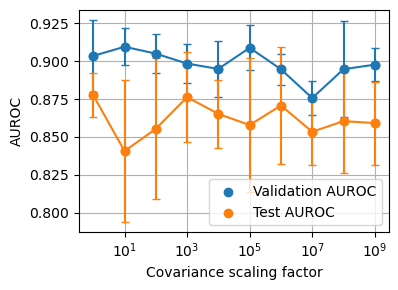

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
# Validation
ax.plot(df.prior_scale, df.val_auroc, color='#1f77b4')
ax.scatter(df.prior_scale, df.val_auroc, label='Validation AUROC', color='#1f77b4')
ax.errorbar(df.prior_scale, df.val_auroc, yerr=df.val_auroc_std, fmt='o', capsize=3, color='#1f77b4')
# Test
ax.plot(df.prior_scale, df.test_auroc, color='#ff7f0e')
ax.scatter(df.prior_scale, df.test_auroc, label='Test AUROC', color='#ff7f0e')
ax.errorbar(df.prior_scale, df.test_auroc, yerr=df.test_auroc_std, fmt='o', capsize=3, color='#ff7f0e')
# Formatting
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('AUROC')
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

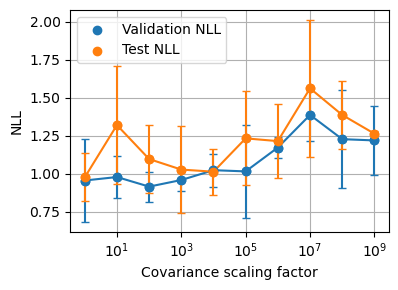

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
# Validation
ax.plot(df.prior_scale, df.val_nll, color='#1f77b4')
ax.scatter(df.prior_scale, df.val_nll, label='Validation NLL', color='#1f77b4')
ax.errorbar(df.prior_scale, df.val_nll, yerr=df.val_nll_std, fmt='o', capsize=3, color='#1f77b4')
# Test
ax.plot(df.prior_scale, df.test_nll, color='#ff7f0e')
ax.scatter(df.prior_scale, df.test_nll, label='Test NLL', color='#ff7f0e')
ax.errorbar(df.prior_scale, df.test_nll, yerr=df.test_nll_std, fmt='o', capsize=3, color='#ff7f0e')
# Formatting
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('NLL')
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()